## MULTIVARIATE LINEAR REGRESSION MODEL

OverallQual - Overall material and finish quality of the house.

GrLivArea - Above-ground living area (square feet).

GarageCars - Number of cars that fit in the garage.

GarageArea - Size of the garage in square feet.

TotalBsmtSF - Total square feet of the basement area.

1stFlrSF - First-floor square footage.

FullBath - Number of full bathrooms.

TotRmsAbvGrd - Total number of rooms above ground.

YearBuilt - Year the house was built.

YearRemodAdd - Year the house was remodeled or added.

SalePrice - Sale price of the house (Target variable for prediction)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_df = pd.read_csv(r"D:\workspace\python programs\train (7).csv")
test_df = pd.read_csv(r"D:\workspace\python programs\test (5).csv")

In [2]:
train_skew_values = pd.DataFrame(train_df.skew(), columns = ['skew values'])
train_skew_values

,skew values
OverallQual,0.232100
GrLivArea,1.414698
GarageCars,-0.320204
GarageArea,0.161227
TotalBsmtSF,1.724076
1stFlrSF,1.476266
FullBath,0.056752
TotRmsAbvGrd,0.603936
YearBuilt,-0.614846
YearRemodAdd,-0.507757


In [3]:
test_skew_values = pd.DataFrame(test_df.skew(), columns = ['skew values'])
test_skew_values

,skew values
OverallQual,0.173926
GrLivArea,1.196255
GarageCars,-0.416474
GarageArea,0.261242
TotalBsmtSF,0.526471
1stFlrSF,0.958848
FullBath,-0.016203
TotRmsAbvGrd,0.892686
YearBuilt,-0.605248
YearRemodAdd,-0.486860


In [4]:
def log_transform(train_df, test_df, features):
    for feature in features:
        train_df[feature] = np.log1p(train_df[feature])
        test_df[feature] = np.log1p(test_df[feature])
        
log_transform(train_df, test_df, ['SalePrice'])#['SalePrice','GrLivArea','1stFlrSF','TotRmsAbvGrd'])

train_df = train_df[:]
train_rows = train_df.shape[0]
# ['SalePrice','GrLivArea','1stFlrSF','TotRmsAbvGrd'] gave equal training and testing accuracies

In [5]:
train_skew_values = pd.DataFrame(train_df.skew(), columns = ['skew value'])
train_skew_values

,skew value
OverallQual,0.232100
GrLivArea,1.414698
GarageCars,-0.320204
GarageArea,0.161227
TotalBsmtSF,1.724076
1stFlrSF,1.476266
FullBath,0.056752
TotRmsAbvGrd,0.603936
YearBuilt,-0.614846
YearRemodAdd,-0.507757


In [6]:
test_skew_values = pd.DataFrame(test_df.skew(), columns = ['skew value'])
test_skew_values

,skew value
OverallQual,0.173926
GrLivArea,1.196255
GarageCars,-0.416474
GarageArea,0.261242
TotalBsmtSF,0.526471
1stFlrSF,0.958848
FullBath,-0.016203
TotRmsAbvGrd,0.892686
YearBuilt,-0.605248
YearRemodAdd,-0.486860


## GENERATING NEW INTERACTION FEATURES FOR BETTER LEARNING

In [7]:
def addition(train_df, test_df, new_name, cols):
    train_df[new_name] = 0
    test_df[new_name] = 0
    
    for col in cols:
        train_df[new_name] += train_df[col]
        test_df[new_name] += test_df[col]

def interaction(train_df, test_df, new_name, cols):
    train_df[new_name] = 1
    test_df[new_name] = 1
    
    for col in cols:
        train_df[new_name] *= train_df[col]
        test_df[new_name] *= test_df[col]
 
#on the first 4 elements, model has perfect equal training and testing accuracy. using the 0th, 2nd, 4th, 7th, 8th, 9th combos, model has perfect
#training and testing accuracy

synergy_combos = {
    #'GrdValue': ['TotRmsAbvGrd', 'GrLivArea'], 
    #'GarValue': ['GarageCars', 'GarageArea'],
    'Freshness': ['YearRemodAdd', 'OverallQual'], 
    #'AreaValue': ['TotalBsmtSF', '1stFlrSF'],
    'QualArea': ['OverallQual', 'GrLivArea'],
    #'BathArea': ['FullBath', 'GrLivArea'],
    #'MainArea':  ['1stFlrSF','GrLivArea'],
    'GenValue': ['OverallQual','YearBuilt'],
    'RoomQual': ['OverallQual','TotRmsAbvGrd'],
    'RemodExp': ['YearRemodAdd','OverallQual','GrLivArea'],
    
    #'GarageQual': ['GarageArea', 'OverallQual']
}

additive_combos = {   
    'TotArea': ['TotalBsmtSF', '1stFlrSF','GrLivArea','GarageArea']
}

for term in additive_combos:
    addition(train_df, test_df, term, additive_combos[term])
    
for term in synergy_combos:
    interaction(train_df, test_df, term, synergy_combos[term])

In [8]:
corr_matrix = train_df.corr()
corr_matrix.style.background_gradient(cmap = 'cool').format(precision = 2)

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,SalePrice,TotArea,Freshness,QualArea,GenValue,RoomQual,RemodExp
OverallQual,1.00,0.60,0.60,0.59,0.56,0.49,0.55,0.43,0.58,0.55,0.82,0.68,1.00,0.81,1.00,0.82,0.81
GrLivArea,0.60,1.00,0.47,0.50,0.46,0.57,0.62,0.82,0.22,0.27,0.70,0.81,0.60,0.93,0.59,0.85,0.93
GarageCars,0.60,0.47,1.00,0.89,0.44,0.44,0.50,0.37,0.55,0.43,0.69,0.62,0.61,0.56,0.62,0.57,0.56
GarageArea,0.59,0.50,0.89,1.00,0.50,0.50,0.44,0.36,0.50,0.40,0.67,0.69,0.59,0.58,0.60,0.56,0.58
TotalBsmtSF,0.56,0.46,0.44,0.50,1.00,0.81,0.32,0.28,0.40,0.30,0.61,0.85,0.56,0.57,0.56,0.50,0.57
1stFlrSF,0.49,0.57,0.44,0.50,0.81,1.00,0.39,0.41,0.30,0.25,0.60,0.89,0.49,0.61,0.49,0.53,0.61
FullBath,0.55,0.62,0.50,0.44,0.32,0.39,1.00,0.55,0.49,0.44,0.60,0.55,0.56,0.62,0.56,0.63,0.62
TotRmsAbvGrd,0.43,0.82,0.37,0.36,0.28,0.41,0.55,1.00,0.11,0.17,0.53,0.61,0.43,0.71,0.42,0.84,0.71
YearBuilt,0.58,0.22,0.55,0.50,0.40,0.30,0.49,0.11,1.00,0.60,0.59,0.40,0.59,0.38,0.62,0.39,0.38
YearRemodAdd,0.55,0.27,0.43,0.40,0.30,0.25,0.44,0.17,0.60,1.00,0.56,0.35,0.58,0.40,0.57,0.41,0.41


## GRAPHICAL REPRESENTATION OF ALL FEATURES WITH RESPECT TO SALE PRICE

We do this to check for any obvious outlier that might be present in a feature. Then we choose the features where outliers are present and remove them using a lenient IQR filter. The indices of the datasets are then reset for proper alignment during linear regression operations.

In [9]:
def target_decider(df,target_name):
    x = df.drop(target_name, axis = 1)
    y = pd.DataFrame(df[target_name].values.reshape(-1,1), columns = [target_name])
    return x, y

def plotter(x, y, col):
    plt.scatter(x[col], y, color = 'black')
    plt.xlabel(col)
    plt.ylabel(f"{y.columns.values[0]}")
    
def multi_plotter(df, features, target):
    i = 0
    for col in features:
        color = ['deeppink', 'yellow', 'cyan', 'green', 'black', 'magenta','blueviolet', 'orange' , 'lime', 'blue', 'red']
        plt.scatter(df[col], df[target], color = color[i % 10], label = col)
        plt.xlabel("ALL FEATURES")
        plt.ylabel(f"{target[0]}")
        i+=1
    plt.legend(title = 'FEATURES')

def line_plotter(coeff, lower_x, upper_x, col, best_fit = 0): #as a subset of plotter and multi_plotter
    m, b = coeff
    m = np.abs(m)
    b = abs(b)
    
    if best_fit:
        plt.plot(list(range(lower_x, upper_x)), [m.max() * x + b for x in range(lower_x, upper_x)], color='red')
    else:
        plt.plot(list(range(lower_x, upper_x)), [m[encoded_features[col]] * x + b for x in range(lower_x, upper_x)], color='red')

def prediction_plotter(test_df, coeff, x_test, y_test, col): #as a subset of plotter
    m, b = coeff
    plt.scatter(test_df[col], y_test, color = 'black', label = 'Expected points')
    plt.scatter(test_df[col], np.dot(x_test, m) + b, color= 'red', label = 'Predicted points')
    plt.legend(title = 'LEGEND')

In [10]:
outlier_features = list(train_df.columns.values)[:-1]

Q1 = train_df[outlier_features].quantile(0.25)
Q3 = train_df[outlier_features].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + IQR * 5

train_df = train_df[(train_df[outlier_features] <= upper_bound).all(axis=1)]
train_df = train_df.reset_index(drop=True)

print(f"{train_rows-train_df.shape[0]} rows removed after outlier removal.")

2 rows removed after outlier removal.


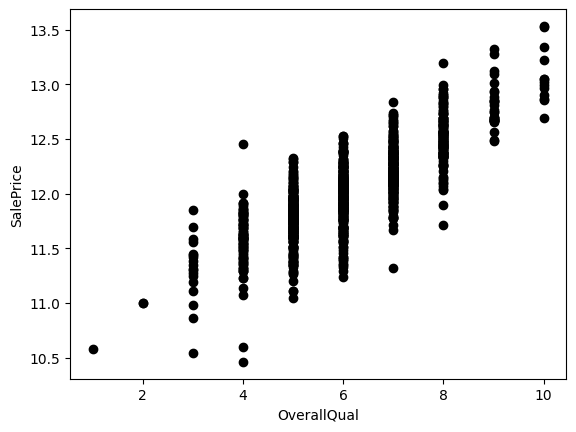

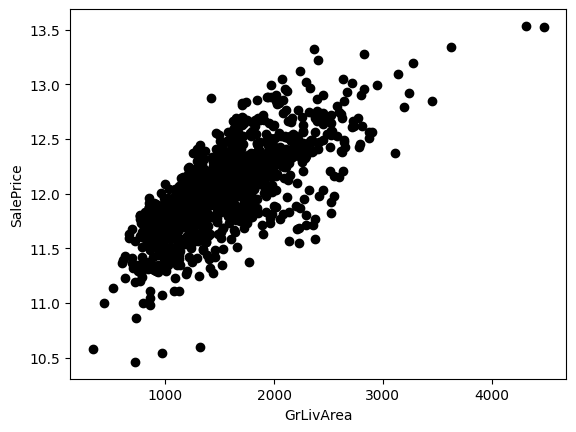

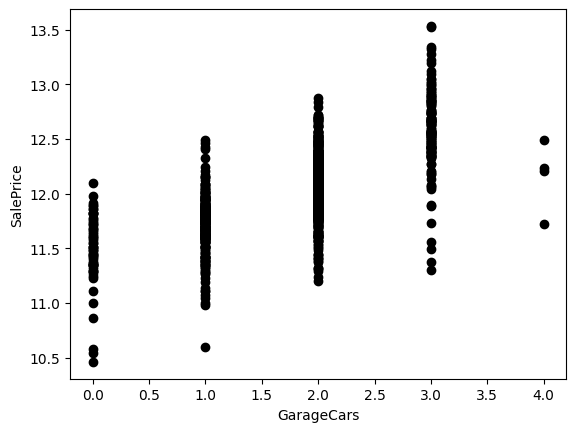

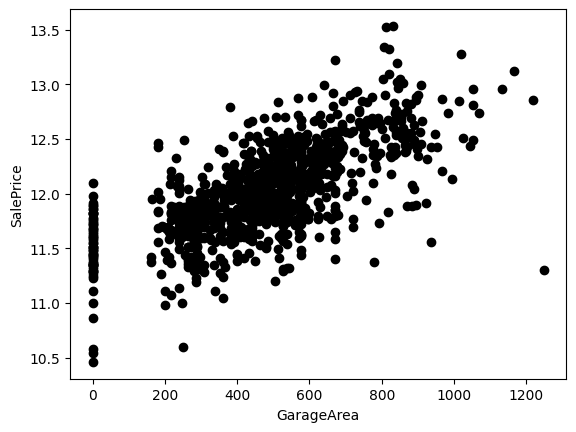

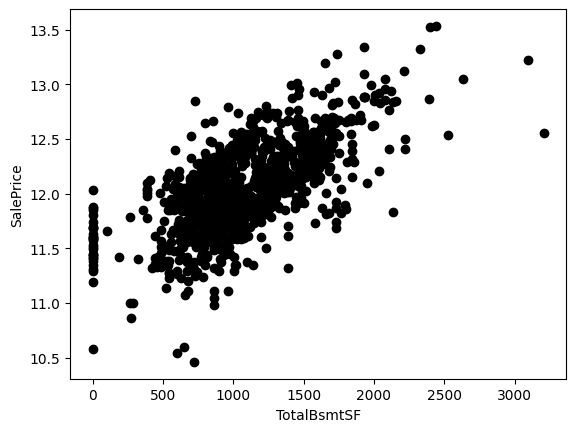

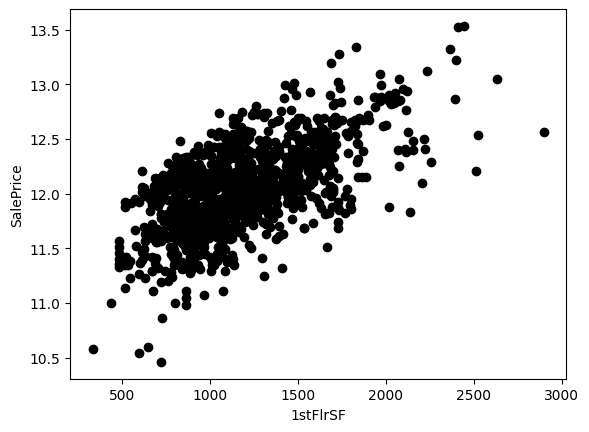

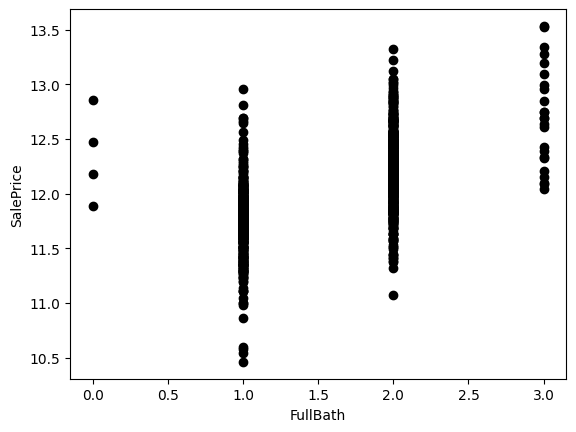

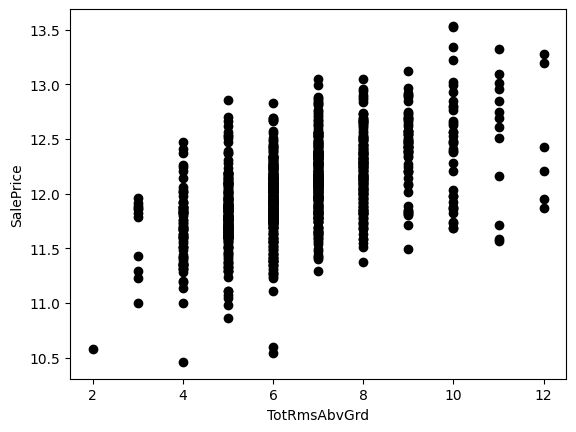

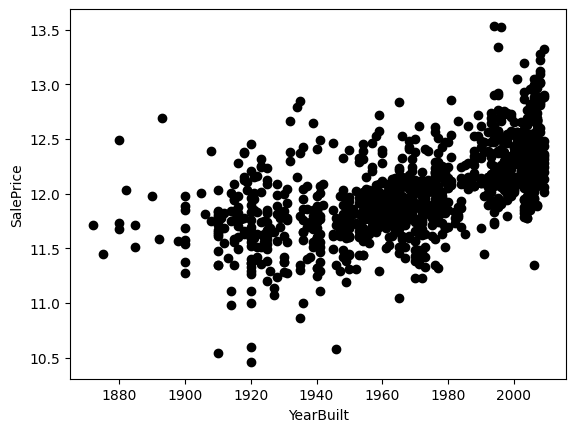

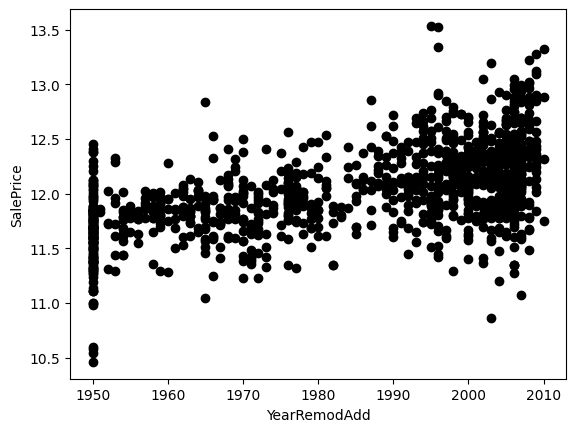

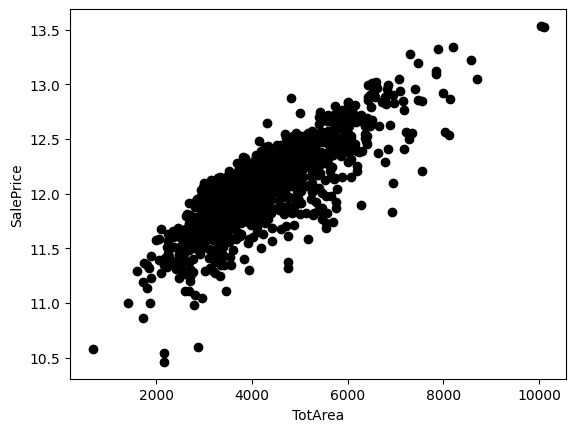

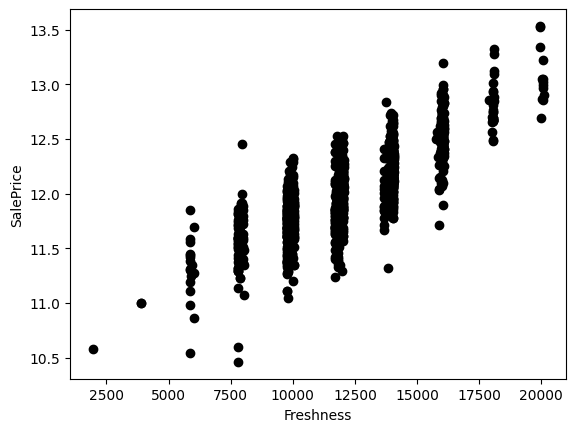

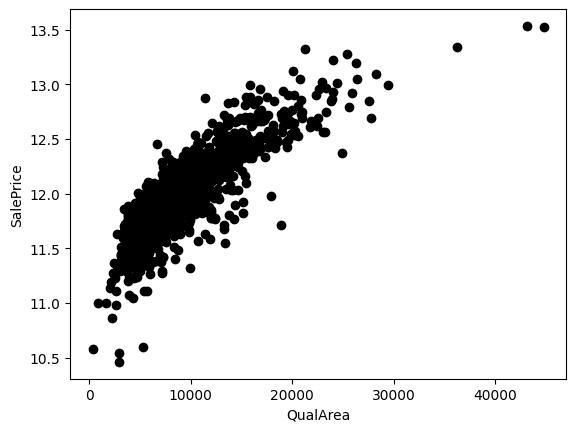

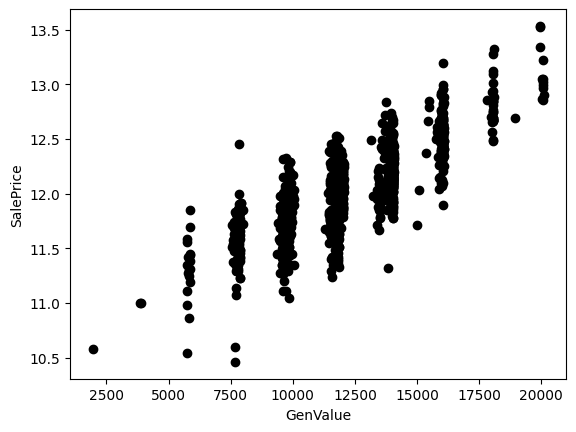

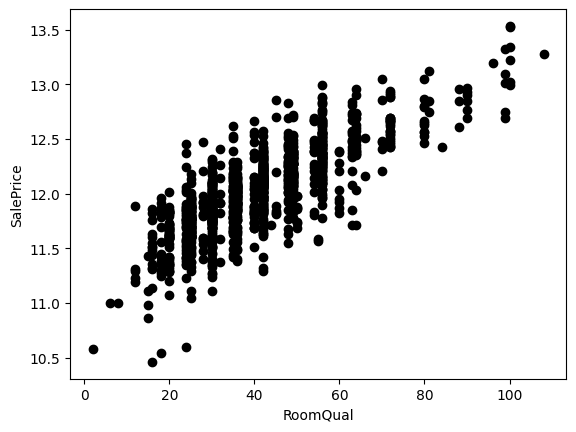

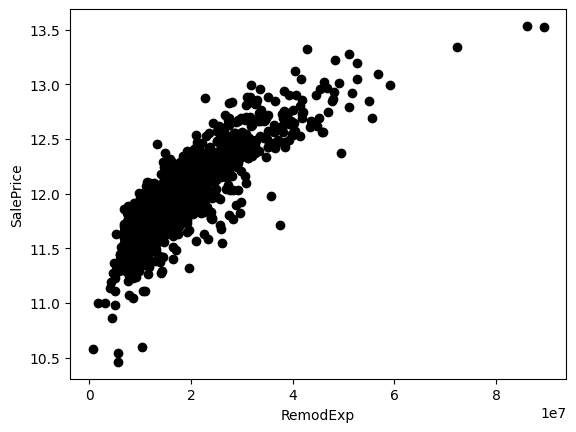

In [11]:
x1, y1 = target_decider(train_df,'SalePrice')
x2, y2 = target_decider(test_df, 'SalePrice')

features = list(x1.columns.values)
target = list(y1.columns.values)
encoded_features = dict()

for i, feature in enumerate(features):
    encoded_features[feature] = i

for col in features:
    plotter(x1, y1, col)
    plt.show()

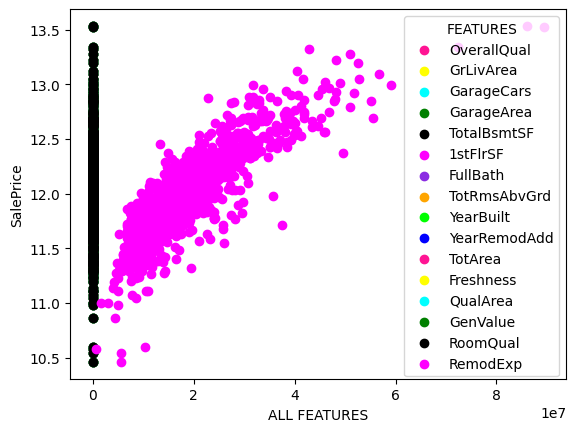

In [12]:
multi_plotter(train_df, features, target)
plt.show()

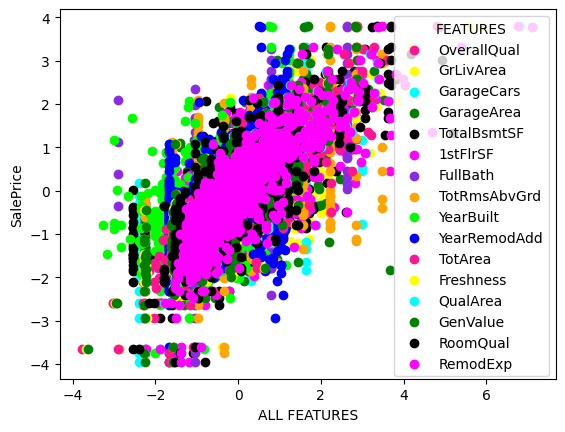

In [13]:
def feature_scale(df,train_df, columns):
    scaled_df = df.copy()
    for col in columns:
        scaled_df[col] = ( scaled_df[col] - train_df[col].mean() ) / train_df[col].std()
    return scaled_df

x_train, y_train = feature_scale(x1, x1, features), pd.DataFrame(feature_scale(y1, y1, target),columns = target)
x_test, y_test = feature_scale(x2, x1, features), pd.DataFrame(feature_scale(y2, y1, target),columns = target)

fscaled_df = feature_scale(train_df, train_df, train_df.columns.values)
multi_plotter(fscaled_df, features, target)
plt.show()

## COMPONENTS OF THE LINEAR REGRESSION MODEL

In [14]:
def MSE(y, yp, n):
    error = np.sum((y - yp) ** 2)
    return error / n

def r2score(y, yp):
    TSS = np.sum((y - np.mean(y)) ** 2)
    SSE = np.sum((y - yp) ** 2)
    return (1 - (SSE / TSS))
    
def batch_divider(feature_array, target_array, size):
    batches = []
    i = 0
    while i < len(feature_array):
        X_batch = feature_array[i:i + size]
        Y_batch = target_array[i:i + size]
        batches.append((X_batch, Y_batch))
        i += size
    return batches

def gradient_desc(X, Y, m, b, LR, y_pred, n, λ = 0):
    y_pred = np.dot(X, m) + b  
    error = y_pred - Y  

    m_gradient = (2 / n) * (np.dot(X.T, error) + m*λ)
    b_gradient = (2 / n) * np.sum(error)

    m -= LR * m_gradient
    b -= LR * b_gradient
    
    return m, b, y_pred, LR


## LINEAR REGRESSION

In [15]:
def Linear_Regression(x_train, y_train, LR, epochs, size, λ = 0):
    x = x_train.values
    y = y_train.values.reshape(-1)

    rows, columns = x.shape
    m = np.zeros(columns)
    b = 0

    batches = batch_divider(x, y, size)
    accuracy_list = []
    coeff = [] 
    costs_list = []

    i = 0
    for X_batch, Y_batch in batches:
        X = X_batch
        Y = Y_batch.reshape(-1)
        n = len(X)   
        
        y_pred = 0
        for epoch in range(epochs):
            m, b, y_pred, LR = gradient_desc(X, Y, m, b, LR, y_pred, n, λ)

            if epoch % 1 == 0:
                cost = MSE(Y, y_pred, n) + λ * np.sum(m**2)
                print(epoch, cost)
                costs_list.append(cost)
                
            
        accuracy = r2score(Y,y_pred)

        if i != len(batches) - 1 or (i == len(batches) - 1 and rows % size == 0): 
            coeff.append((m,b))
            accuracy_list.append(accuracy)
        i+=1

    m_net = np.average([m for m, _ in coeff], axis = 0)
    b_net = np.average([b for _, b in coeff])
    
    plt.plot( range(len(costs_list)),np.array(costs_list))
    plt.title("Cost vs epoch")
    plt.show()
    
    return (m_net, b_net)

## TUNING THE PARAMETERS

0 0.9991423670668954
1 0.1585456322445306
2 0.1560549517079768
3 0.15417279211386747
4 0.15271961071254728
5 0.1515713650931225
6 0.15064211123980736
7 0.14987209511077443
8 0.1492195938600894
9 0.14865532102261694
10 0.14815858599445295
11 0.1477146546570669
12 0.14731293304873203
13 0.1469457154966636
14 0.1466073202469964
15 0.1462934914039411
16 0.14600098412036033
17 0.14572727606586997
18 0.14547036605297506
19 0.14522863293178886
20 0.1450007362479217
21 0.14478554591066842
22 0.14458209206945638
23 0.1443895291128886
24 0.14420710957458652
25 0.14403416501893343
26 0.1438700918695776
27 0.1437143407588036
28 0.14356640840210586
29 0.14342583129818695
30 0.14329218076049244
31 0.1431650589300304
32 0.1430440955197266
33 0.14292894511111592
34 0.14281928487388115
35 0.14271481261391888
36 0.14261524508061194
37 0.1425203164818498
38 0.14242977716817642
39 0.14234339245673275
40 0.1422609415724288
41 0.1421822166887518
42 0.1421070220543023
43 0.14203517319390596
44 0.141966496175

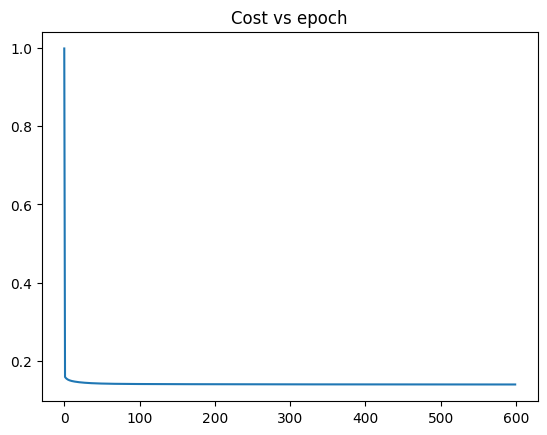

array([ 8.90485375e-02,  2.79062821e-01,  6.39450233e-02,  5.12083248e-02,
        1.02852919e-01, -2.70577032e-05, -4.89274064e-02, -2.21233089e-02,
        1.52401141e-01,  1.13678828e-01,  1.59184224e-01,  8.27504766e-02,
        3.16959809e-02,  6.60171570e-02,  1.54262762e-02,  3.43329881e-02])

In [37]:
#0.1, 584, 8000, 0 gave equal training and testing accuracy upto 2 decimal places. similarly after log transform and more interaction terms,
#0.09, 10000, 0.2
LR = 0.05
size = train_df.shape[0]
epochs = 600
λ = 0
net_coeff = Linear_Regression(x_train, y_train, LR, epochs, size, λ)
net_coeff[0]

## VISUALISING THE PREDICTIONS

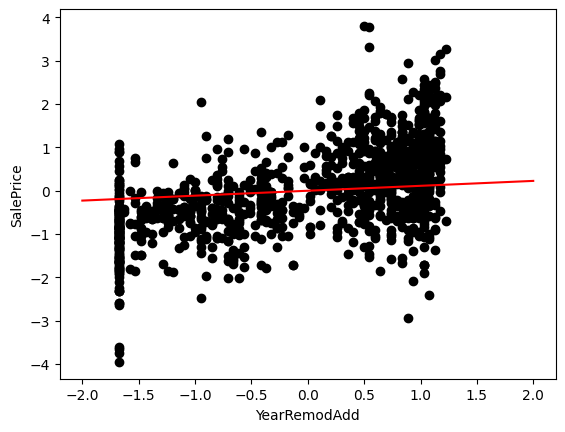

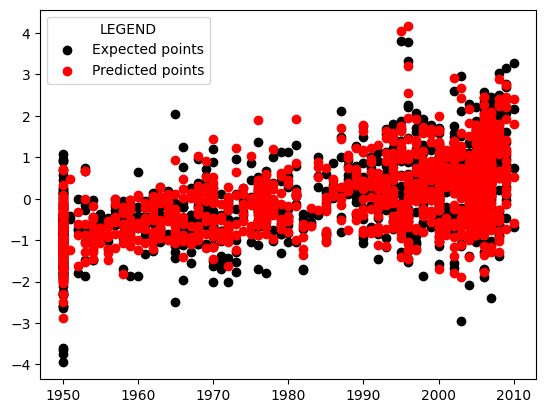

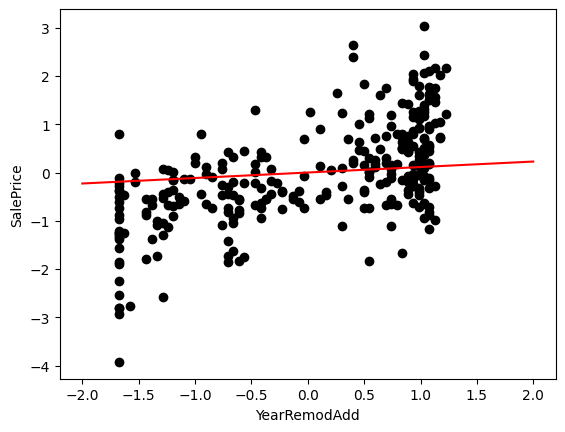

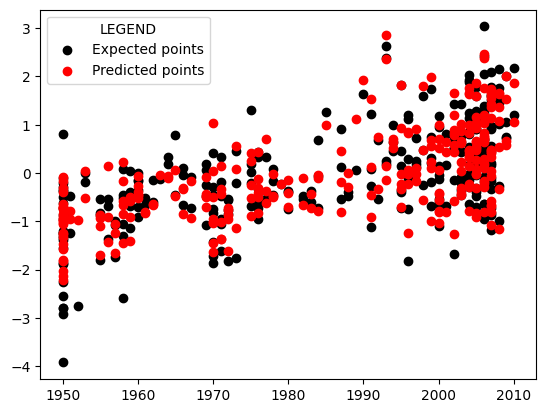

TRAIN ACCURACY: 86.06%
TEST ACCURACY: 84.60%


C:\Users\GARV OFFLINE\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [38]:
xi = -2
xf = 3
x_feature = "YearRemodAdd"
m = pd.DataFrame(net_coeff[0], columns = target) 
b = net_coeff[1]
best_fit = False

y = train_df[target]

plotter(x_train, y_train, x_feature)

line_plotter(net_coeff, xi, xf, x_feature, best_fit = best_fit)
plt.show()

prediction_plotter(train_df, net_coeff, x_train, y_train, x_feature)
plt.show()

plotter(x_test, y_test, x_feature)
line_plotter(net_coeff, xi, xf, x_feature, best_fit = best_fit)
plt.show()

prediction_plotter(test_df, net_coeff, x_test, y_test, x_feature)
plt.show()

accuracy = r2score(y_train, np.dot(x_train, m) + b)
accuracy_test = r2score(y_test, np.dot(x_test, m) + b)
print(f"TRAIN ACCURACY: {accuracy.iloc[0]*100:.2f}%")
print(f"TEST ACCURACY: {accuracy_test.iloc[0]*100:.2f}%")


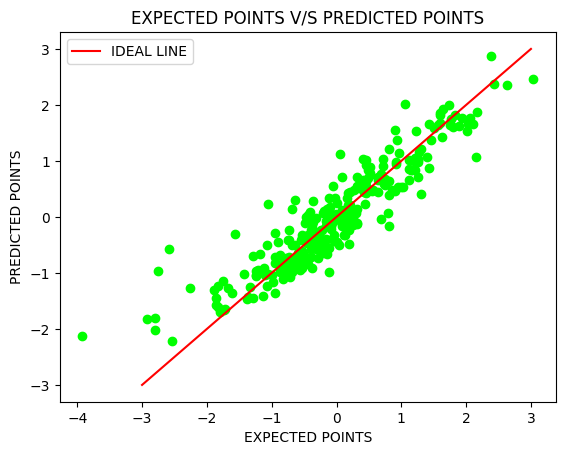

In [39]:
x = np.linspace(-3,3,100)
y = x
plt.scatter(y_test, (np.dot(x_test, m)) + b, color = 'lime')
plt.plot(x, y, color = 'red', label = 'IDEAL LINE')
plt.xlabel('EXPECTED POINTS')
plt.ylabel('PREDICTED POINTS')
plt.title('EXPECTED POINTS V/S PREDICTED POINTS')
plt.legend()
plt.show()